# 4. Transformation and Selection

In the previous lesson, we identified stars with the proper motion we expect for GD-1.

Now we'll do the same selection in an ADQL query, which will make it possible to work with a larger region of the sky and still download less data.

## Outline

Here are the steps in this lesson:

1. Using data from the previous lesson, we'll identify the values of proper motion for stars likely to be in GD-1.

2. Then we'll compose an ADQL query that selects stars based on proper motion, so we can download only the data we need.

That will make it possible to search a bigger region of the sky in a single query.
We'll also see how to write the results to a CSV file.

After completing this lesson, you should be able to

* Transform proper motions from one frame to another.

* Compute the convex hull of a set of points.

* Write an ADQL query that selects based on proper motion.

* Save data in CSV format.

## Installing libraries

If you are running this notebook on Colab, you can run the following cell to install the libraries we'll use.

If you are running this notebook on your own computer, you might have to install these libraries yourself.  See the instructions in the preface.

In [1]:
# If we're running on Colab, install libraries

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install astroquery astro-gala wget

## Reload the data

The following cells download the data from the previous lesson, if necessary, and load it into a Pandas `DataFrame`.

In [ ]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/AstronomicalData/raw/main/' +
         'data/gd1_data.hdf')

In [7]:
import pandas as pd

filename = 'gd1_data.hdf'

centerline_df = pd.read_hdf(filename, 'centerline_df')
selected_df = pd.read_hdf(filename, 'selected_df')

## Selection by proper motion

Let's review how we got to this point.

1. We made an ADQL query to the Gaia server to get data for stars in the vicinity of GD-1.

2. We transformed the coordinates to the `GD1Koposov10` frame so we could select stars along the centerline of GD-1.

3. We plotted the proper motion of the centerline stars to identify the bounds of the overdense region.

4. We made a mask that selects stars whose proper motion is in the overdense region.

At this point we have downloaded data for a relatively large number of stars (more than 100,000) and selected a relatively small number (around 1000).

It would be more efficient to use ADQL to select only the stars we need.  That would also make it possible to download data covering a larger region of the sky.

However, the selection we did was based on proper motion in the `GD1Koposov10` frame.  In order to do the same selection in ADQL, we have to work with proper motions in ICRS.

As a reminder, here's the rectangle we selected based on proper motion in the `GD1Koposov10` frame.

In [8]:
pm1_min = -8.9
pm1_max = -6.9
pm2_min = -2.2
pm2_max =  1.0

In [9]:
def make_rectangle(x1, x2, y1, y2):
    """Return the corners of a rectangle."""
    xs = [x1, x1, x2, x2, x1]
    ys = [y1, y2, y2, y1, y1]
    return xs, ys

In [10]:
pm1_rect, pm2_rect = make_rectangle(
    pm1_min, pm1_max, pm2_min, pm2_max)

Since we'll need to plot proper motion several times, we'll use the following function.

In [11]:
import matplotlib.pyplot as plt

def plot_proper_motion(df):
    """Plot proper motion.
    
    df: DataFrame with `pm_phi1` and `pm_phi2`
    """
    x = df['pm_phi1']
    y = df['pm_phi2']
    plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

    plt.xlabel('Proper motion phi1 (GD1 frame)')
    plt.ylabel('Proper motion phi2 (GD1 frame)')

    plt.xlim(-12, 8)
    plt.ylim(-10, 10)

The following figure shows:

* Proper motion for the stars we selected along the center line of GD-1,

* The rectangle we selected, and

* The stars inside the rectangle highlighted in green.

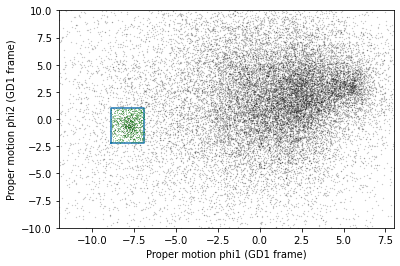

In [12]:
plot_proper_motion(centerline_df)

plt.plot(pm1_rect, pm2_rect)

x = selected_df['pm_phi1']
y = selected_df['pm_phi2']
plt.plot(x, y, 'gx', markersize=0.3, alpha=0.3);

Now we'll make the same plot using proper motions in the ICRS frame, which are stored in columns `pmra` and `pmdec`.

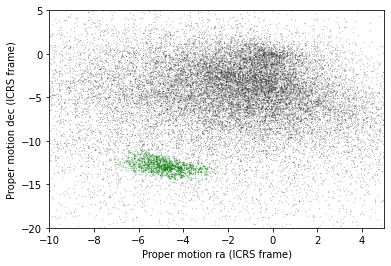

In [13]:
x = centerline_df['pmra']
y = centerline_df['pmdec']
plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

x = selected_df['pmra']
y = selected_df['pmdec']
plt.plot(x, y, 'gx', markersize=1, alpha=0.3)
    
plt.xlabel('Proper motion ra (ICRS frame)')
plt.ylabel('Proper motion dec (ICRS frame)')

plt.xlim([-10, 5])
plt.ylim([-20, 5]);

The proper motions of the selected stars are more spread out in this frame, which is why it was preferable to do the selection in the GD-1 frame.

But now we can define a polygon that encloses the proper motions of these stars in ICRS, and use that polygon as a selection criterion in an ADQL query.

## Convex Hull

SciPy provides a function that computes the [convex hull](https://en.wikipedia.org/wiki/Convex_hull) of a set of points, which is the smallest convex polygon that contains all of the points.

To use it, we'll select columns `pmra` and `pmdec` and convert them to a NumPy array.

In [14]:
import numpy as np

points = selected_df[['pmra','pmdec']].to_numpy()
points.shape

(1049, 2)

NOTE: If you are using an older version of Pandas, you might not have `to_numpy()`; you can use `values` instead, like this:

```
points = selected_df[['pmra','pmdec']].values

```

We'll pass the points to `ConvexHull`, which returns an object that contains the results. 

In [15]:
from scipy.spatial import ConvexHull

hull = ConvexHull(points)
hull

`hull.vertices` contains the indices of the points that fall on the perimeter of the hull.

In [16]:
hull.vertices

array([ 692,  873,  141,  303,   42,  622,   45,   83,  127,  182, 1006,
        971,  967, 1001,  969,  940], dtype=int32)

We can use them as an index into the original array to select the corresponding rows.

In [17]:
pm_vertices = points[hull.vertices]
pm_vertices

array([[ -4.05037121, -14.75623261],
       [ -3.41981085, -14.72365546],
       [ -3.03521988, -14.44357135],
       [ -2.26847919, -13.7140236 ],
       [ -2.61172203, -13.24797471],
       [ -2.73471401, -13.09054471],
       [ -3.19923146, -12.5942653 ],
       [ -3.34082546, -12.47611926],
       [ -5.67489413, -11.16083338],
       [ -5.95159272, -11.10547884],
       [ -6.42394023, -11.05981295],
       [ -7.09631023, -11.95187806],
       [ -7.30641519, -12.24559977],
       [ -7.04016696, -12.88580702],
       [ -6.00347705, -13.75912098],
       [ -4.42442296, -14.74641176]])

To plot the resulting polygon, we have to pull out the x and y coordinates.

In [18]:
pmra_poly, pmdec_poly = np.transpose(pm_vertices)

This use of `transpose` is a useful NumPy idiom.  Because `pm_vertices` has two columns, its [matrix transpose](https://en.wikipedia.org/wiki/Transpose) has two rows, which are assigned to the two variables `pmra_poly` and `pmdec_poly`.

The following figure shows proper motion in ICRS again, along with the convex hull we just computed.

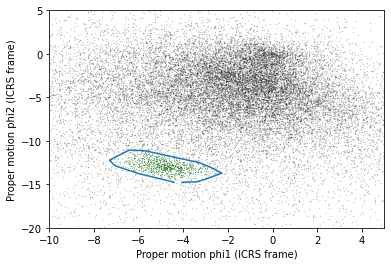

In [19]:
x = centerline_df['pmra']
y = centerline_df['pmdec']
plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

x = selected_df['pmra']
y = selected_df['pmdec']
plt.plot(x, y, 'gx', markersize=0.3, alpha=0.3)

plt.plot(pmra_poly, pmdec_poly)
    
plt.xlabel('Proper motion phi1 (ICRS frame)')
plt.ylabel('Proper motion phi2 (ICRS frame)')

plt.xlim([-10, 5])
plt.ylim([-20, 5]);

So `pm_vertices` represents the polygon we want to select.
The next step is to use it as part of an ADQL query.

## Assembling the query

In Lesson 2 we used the following query to select stars in a polygonal region.

In [26]:
query5_base = """SELECT
{columns}
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON({point_list}))
"""

In this lesson we'll make two changes:

1. We'll select stars with coordinates in a larger region.

2. We'll add another clause to select stars whose proper motion is in the polygon we just computed, `pm_vertices`.

Here are the coordinates of the larger rectangle in the GD-1 frame.

In [27]:
import astropy.units as u

phi1_min = -70 * u.degree
phi1_max = -20 * u.degree
phi2_min = -5 * u.degree
phi2_max = 5 * u.degree

We selected these bounds by trial and error, defining the largest region we can process in a single query.

In [28]:
phi1_rect, phi2_rect = make_rectangle(
    phi1_min, phi1_max, phi2_min, phi2_max)

Here's how we transform it to ICRS, as we saw in Lesson 2.

In [29]:
from gala.coordinates import GD1Koposov10
from astropy.coordinates import SkyCoord

gd1_frame = GD1Koposov10()
corners = SkyCoord(phi1=phi1_rect, 
                   phi2=phi2_rect, 
                   frame=gd1_frame)

corners_icrs = corners.transform_to('icrs')

To use `corners_icrs` as part of an ADQL query, we have to convert it to a string.  
Here's the function from Lesson 2 we used to do that.

In [30]:
def skycoord_to_string(skycoord):
    """Convert SkyCoord to string."""
    t = skycoord.to_string()
    s = ' '.join(t)
    return s.replace(' ', ', ')

In [31]:
point_list = skycoord_to_string(corners_icrs)
point_list

'135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862'

Here are the columns we want to select.

In [32]:
columns = 'source_id, ra, dec, pmra, pmdec'

Now we have everything we need to assemble the query.


In [33]:
query5 = query5_base.format(columns=columns, 
                            point_list=point_list)
print(query5)

SELECT
source_id, ra, dec, pmra, pmdec
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON(135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))



But don't try to run that query.
Because it selects a larger region, there are too many stars to handle in a single query.
Until we select by proper motion, that is.

## Selecting proper motion

Now we're ready to add a `WHERE` clause to select stars whose proper motion falls in the polygon defined by `pm_vertices`.

To use `pm_vertices` as part of an ADQL query, we have to convert it to a string.
Using `flatten` and `array2string`, we can almost get the format we need.

In [34]:
s = np.array2string(pm_vertices.flatten(), 
                    max_line_width=1000,
                    separator=',')
s

'[ -4.05037121,-14.75623261, -3.41981085,-14.72365546, -3.03521988,-14.44357135, -2.26847919,-13.7140236 , -2.61172203,-13.24797471, -2.73471401,-13.09054471, -3.19923146,-12.5942653 , -3.34082546,-12.47611926, -5.67489413,-11.16083338, -5.95159272,-11.10547884, -6.42394023,-11.05981295, -7.09631023,-11.95187806, -7.30641519,-12.24559977, -7.04016696,-12.88580702, -6.00347705,-13.75912098, -4.42442296,-14.74641176]'

We just have to remove the brackets.

In [35]:
pm_point_list = s.strip('[]')
pm_point_list

' -4.05037121,-14.75623261, -3.41981085,-14.72365546, -3.03521988,-14.44357135, -2.26847919,-13.7140236 , -2.61172203,-13.24797471, -2.73471401,-13.09054471, -3.19923146,-12.5942653 , -3.34082546,-12.47611926, -5.67489413,-11.16083338, -5.95159272,-11.10547884, -6.42394023,-11.05981295, -7.09631023,-11.95187806, -7.30641519,-12.24559977, -7.04016696,-12.88580702, -6.00347705,-13.75912098, -4.42442296,-14.74641176'

### Exercise

Define `query6_base`, starting with `query5_base` and adding a new clause to select stars whose coordinates of proper motion, `pmra` and `pmdec`, fall within the polygon defined by `pm_point_list`.

In [36]:
# Solution

query6_base = """SELECT 
{columns}
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON({point_list}))
  AND 1 = CONTAINS(POINT(pmra, pmdec),
                   POLYGON({pm_point_list}))
"""

### Exercise

Use `format` to format `query6_base` and define `query6`, filling in the values of `columns`, `point_list`, and `pm_point_list`.

In [37]:
# Solution

query6 = query6_base.format(columns=columns, 
                          point_list=point_list,
                          pm_point_list=pm_point_list)
print(query6)

SELECT 
source_id, ra, dec, pmra, pmdec
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2 
  AND 1 = CONTAINS(POINT(ra, dec), 
                   POLYGON(135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))
  AND 1 = CONTAINS(POINT(pmra, pmdec),
                   POLYGON( -4.05037121,-14.75623261, -3.41981085,-14.72365546, -3.03521988,-14.44357135, -2.26847919,-13.7140236 , -2.61172203,-13.24797471, -2.73471401,-13.09054471, -3.19923146,-12.5942653 , -3.34082546,-12.47611926, -5.67489413,-11.16083338, -5.95159272,-11.10547884, -6.42394023,-11.05981295, -7.09631023,-11.95187806, -7.30641519,-12.24559977, -7.04016696,-12.88580702, -6.00347705,-13.75912098, -4.42442296,-14.74641176))



Now we can run the query like this:

In [38]:
from astroquery.gaia import Gaia

job = Gaia.launch_job_async(query6)
print(job)

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
INFO: Query finished. [astroquery.utils.tap.core]
<Table length=7345>
   name    dtype    unit                              description                            
--------- ------- -------- ------------------------------------------------------------------
source_id   int64          Unique source identifier (unique within a particular Data Release)
       ra float64      deg                                                    Right ascension
      dec float64      deg                                                        Declination
     pmra float64 mas / yr                         Proper motion in right ascension direction
    pmdec float64 mas / yr                             Proper motion in declination direction
Jobid: 1615824245107O
Phase: COMPLETED
Owner: None
Output file

And get the results.

In [39]:
candidate_table = job.get_results()
len(candidate_table)

7345

We call the results `candidate_table` because it contains stars that are good candidates for GD-1.

## Plotting one more time

Let's see what the results look like.

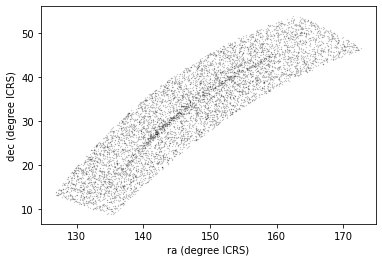

In [40]:
x = candidate_table['ra']
y = candidate_table['dec']
plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.xlabel('ra (degree ICRS)')
plt.ylabel('dec (degree ICRS)');

Here we can see why it was useful to transform these coordinates.  In ICRS, it is more difficult to identity the stars near the centerline of GD-1.

So let's transform the results back to the GD-1 frame.
Here's the code we used to transform the coordinates and make a Pandas `DataFrame`, wrapped in a function.

In [41]:
from gala.coordinates import reflex_correct

def make_dataframe(table):
    """Transform coordinates from ICRS to GD-1 frame.
    
    table: Astropy Table
    
    returns: Pandas DataFrame
    """
    skycoord = SkyCoord(
               ra=table['ra'], 
               dec=table['dec'],
               pm_ra_cosdec=table['pmra'],
               pm_dec=table['pmdec'], 
               distance=8*u.kpc, 
               radial_velocity=0*u.km/u.s)

    gd1_frame = GD1Koposov10()
    transformed = skycoord.transform_to(gd1_frame)
    skycoord_gd1 = reflex_correct(transformed)

    df = table.to_pandas()
    df['phi1'] = skycoord_gd1.phi1
    df['phi2'] = skycoord_gd1.phi2
    df['pm_phi1'] = skycoord_gd1.pm_phi1_cosphi2
    df['pm_phi2'] = skycoord_gd1.pm_phi2
    return df

Here's how we use it:

In [42]:
candidate_df = make_dataframe(candidate_table)

And let's see the results.

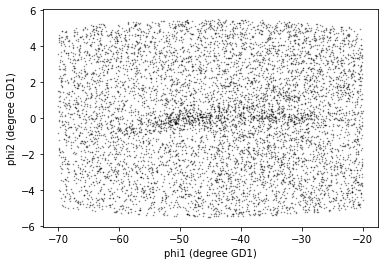

In [43]:
x = candidate_df['phi1']
y = candidate_df['phi2']
plt.plot(x, y, 'ko', markersize=0.5, alpha=0.5)

plt.xlabel('phi1 (degree GD1)')
plt.ylabel('phi2 (degree GD1)');

We're starting to see GD-1 more clearly.
We can compare this figure with this panel from Figure 1 from the original paper:

<img height="150" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-2.png">

This panel shows stars selected based on proper motion only, so it is comparable to our figure (although notice that it covers a wider region).

In the next lesson, we will use photometry data from Pan-STARRS to do a second round of filtering, and see if we can replicate this panel.

<img height="150" src="https://github.com/datacarpentry/astronomy-python/raw/gh-pages/fig/gd1-4.png">

Later we'll see how to add annotations like the ones in the figure and customize the style of the figure to present the results clearly and compellingly.

## Saving the DataFrame

Let's save this `DataFrame` so we can pick up where we left off without running this query again.

The HDF file should already exist, so we'll add `candidate_df` to it.

In [49]:
filename = 'gd1_data.hdf'

candidate_df.to_hdf(filename, 'candidate_df')

We can use `getsize` to confirm that the file exists and check the size:

In [50]:
from os.path import getsize

MB = 1024 * 1024
getsize(filename) / MB

2.575897216796875

## CSV

Pandas can write a variety of other formats, [which you can read about here](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html).

We won't cover all of them, but one other important one is [CSV](https://en.wikipedia.org/wiki/Comma-separated_values), which stands for "comma-separated values".

CSV is a plain-text format that can be read and written by pretty much any tool that works with data.  In that sense, it is the "least common denominator" of data formats.

However, it has an important limitation: some information about the data gets lost in translation, notably the data types.  If you read a CSV file from someone else, you might need some additional information to make sure you are getting it right.

Also, CSV files tend to be big, and slow to read and write.

With those caveats, here's how to write one:

In [51]:
candidate_df.to_csv('gd1_data.csv')

We can check the file size like this:

In [52]:
getsize('gd1_data.csv') / MB

1.238297462463379

We can see the first few lines like this:

In [55]:
def head(filename, n=3):
    with open(filename) as fp:
        for i in range(n):
            print(next(fp))

In [56]:
head('gd1_data.csv')

,source_id,ra,dec,pmra,pmdec,phi1,phi2,pm_phi1,pm_phi2

0,635559124339440000,137.58671691646745,19.1965441084838,-3.770521900009566,-12.490481778113859,-59.63048941944402,-1.2164852515042963,-7.361362712597496,-0.592632882064492

1,635860218726658176,138.5187065217173,19.09233926905897,-5.941679495793577,-11.346409129876392,-59.247329893833296,-2.016078400820631,-7.527126084640531,1.7487794924176672



On Windows you can use 

```
!dir gd1_data.csv
``` 

to confirm that the file exists and  

```
!type gd1_data.csv
```

to view the contents.

The CSV file contains the names of the columns, but not the data types.

We can read the CSV file back like this:

In [97]:
read_back_csv = pd.read_csv('gd1_data.csv')

Let's compare the first few rows of `candidate_df` and `read_back_csv`

In [98]:
candidate_df.head(3)

,source_id,ra,dec,pmra,pmdec,parallax,phi1,phi2,pm_phi1,pm_phi2
0,635559124339440000,137.586717,19.196544,-3.770522,-12.490482,0.791393,-59.630489,-1.216485,-7.361363,-0.592633
1,635860218726658176,138.518707,19.092339,-5.941679,-11.346409,0.307456,-59.247330,-2.016078,-7.527126,1.748779
2,635674126383965568,138.842874,19.031798,-3.897001,-12.702780,0.779463,-59.133391,-2.306901,-7.560608,-0.741800


In [99]:
read_back_csv.head(3)

,Unnamed: 0,source_id,ra,dec,pmra,pmdec,parallax,phi1,phi2,pm_phi1,pm_phi2
0,0,635559124339440000,137.586717,19.196544,-3.770522,-12.490482,0.791393,-59.630489,-1.216485,-7.361363,-0.592633
1,1,635860218726658176,138.518707,19.092339,-5.941679,-11.346409,0.307456,-59.247330,-2.016078,-7.527126,1.748779
2,2,635674126383965568,138.842874,19.031798,-3.897001,-12.702780,0.779463,-59.133391,-2.306901,-7.560608,-0.741800


Notice that the index in `candidate_df` has become an unnamed column in `read_back_csv`.  The Pandas functions for writing and reading CSV files provide options to avoid that problem, but this is an example of the kind of thing that can go wrong with CSV files.

## Summary

In the previous lesson we downloaded data for a large number of stars and then selected a small fraction of them based on proper motion.

In this lesson, we improved this process by writing a more complex query that uses the database to select stars based on proper motion.  This process requires more computation on the Gaia server, but then we're able to either:

1. Search the same region and download less data, or

2. Search a larger region while still downloading a manageable amount of data.

In the next lesson, we'll learn about the databased `JOIN` operation and use it to download photometry data from Pan-STARRS.

## Best practices

* When possible, "move the computation to the data"; that is, do as much of the work as possible on the database server before downloading the data.

* For most applications, saving data in FITS or HDF5 is better than CSV.  FITS and HDF5 are binary formats, so the files are usually smaller, and they store metadata, so you don't lose anything when you read the file back.

* On the other hand, CSV is a "least common denominator" format; that is, it can be read by practically any application that works with data.